In [ ]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # For 2D visualization of the latent space
from torchvision.utils import make_grid

# Local imports
from classification_multi.model import CCVAE
from classification_multi.dataset import CartoonMultiLabelDataset
from torchvision import transforms

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_PATH = (
    PROJECT_ROOT
    / "classification_multi"
    / "model_weights"
    / "ccvae_multilabel_base.pth"
)

DATA_DIR = (
    PROJECT_ROOT
    / "data"
    / "cartoonset10k"
    / "cartoonset10k"
)

# Use a large batch size to get many points for t-SNE
BATCH_SIZE = 128

print(f"Working on {DEVICE}")


Working on cuda


In [ ]:
# Dataset & Loader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
dataset = CartoonMultiLabelDataset(root_dir=DATA_DIR, transform=transform,target_attributes=["hair_color", "face_color"])
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Loading labels for attributes: ['hair_color', 'face_color'] ...
Dataset loaded successfully. Attribute dimensions: {'hair_color': 10, 'face_color': 11}


In [ ]:
# Load the model
Z_C_DIMS = [16, 16]
Z_NOT_C_DIM = 32

model = CCVAE(
    img_channels=3,
    z_c_dims=Z_C_DIMS,        # List [16, 16], one latent block per attribute
    z_not_c_dim=Z_NOT_C_DIM,  # Shared nuisance / style latent dimension
    num_classes_list=[10, 11]
).to(DEVICE)


In [8]:
state = torch.load(MODEL_PATH, map_location=DEVICE)

new_state = {}

for k, v in state.items():
    k_new = k
    k_new = k_new.replace("priors_embedding", "prior_embeddings")
    k_new = k_new.replace("priors_mu", "prior_mu")
    k_new = k_new.replace("priors_logvar", "prior_logvar")
    new_state[k_new] = v


In [9]:
missing, unexpected = model.load_state_dict(new_state, strict=False)

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model.eval()
print("Model loaded successfully")


Missing keys: []
Unexpected keys: []
Model loaded successfully


In [ ]:
# Getting a reference batch
data_iter = iter(test_loader)
fixed_x, fixed_y = next(data_iter)

fixed_x = fixed_x.to(DEVICE)
fixed_y = fixed_y.to(DEVICE)


## Basic blocks

In [55]:
def encode_to_z(model, x):
    """
    x : (1, 3, 64, 64)

    Returns:
        z : (1, total_dim) - Full latent vector
        z_c_list : [tensor(1, 16), tensor(1, 16)] - List of attribute-specific latents
        z_not_c : (1, 32) - Unsupervised / style latent
    """
    with torch.no_grad():
        h = model.encoder_conv(x)
        mu = model.fc_mu(h)

        # We use the deterministic mean (mu) for analysis and inference
        # Sampling via reparameterization can be used if desired
        z = mu

        # Split the latent vector into attribute-specific and nuisance parts
        split_sizes = model.z_c_dims + [model.z_not_c_dim]
        z_parts = torch.split(z, split_sizes, dim=1)

        z_c_list = z_parts[:-1]  # List of z_c_i
        z_not_c = z_parts[-1]    # Nuisance / style latent

    return z, z_c_list, z_not_c


def probas_from_zc(model, z_c_list):
    """
    z_c_list : List of tensors [z_c_hair, z_c_face]

    Returns:
        probs_list : List of probability tensors [(1, 10), (1, 11)]
    """
    probs_list = []
    with torch.no_grad():
        for i, z_c_i in enumerate(z_c_list):
            logits = model.classifiers[i](z_c_i)
            probs = F.softmax(logits, dim=1)
            probs_list.append(probs)
    return probs_list


def classify_x(model, x):
    """
    x : (1, 3, 64, 64)

    Returns:
        preds : List of predicted class indices [pred_hair, pred_face]
        probs_list : List of probability tensors
    """
    _, z_c_list, _ = encode_to_z(model, x)
    probs_list = probas_from_zc(model, z_c_list)

    preds = []
    for probs in probs_list:
        pred_item = torch.argmax(probs, dim=1).item()
        preds.append(pred_item)

    return preds, probs_list


def generate_random(model, device="cuda"):
    """
    Generate a completely random image by sampling all latent variables.
    """
    with torch.no_grad():
        z_parts = []

        # 1. Random sampling for attribute latents (z_c)
        for dim in model.z_c_dims:
            z_parts.append(torch.randn(1, dim, device=device))

        # 2. Random sampling for nuisance / style latent (z_not_c)
        z_parts.append(torch.randn(1, model.z_not_c_dim, device=device))

        # 3. Concatenate and decode
        z = torch.cat(z_parts, dim=1)
        dec = model.decoder_input(z).view(-1, 64, 4, 4)
        x_gen = model.decoder_conv(dec)

    return x_gen


def generate_conditional(model, class_idxs, device="cuda"):
    """
    Generate an image conditioned on specific attribute classes.

    Args:
        class_idxs : List of class indices [idx_hair, idx_face]
                     Example: [0, 5] -> Hair class 0, Face class 5
    """
    with torch.no_grad():
        z_parts = []

        # For each attribute, generate the corresponding z_c via its conditional prior
        for i, class_idx in enumerate(class_idxs):
            y = torch.tensor([class_idx], device=device)
            num_cls = model.num_classes_list[i]
            y_onehot = F.one_hot(y, num_classes=num_cls).float()

            # Prior network: one-hot -> embedding -> mean
            embed = F.relu(model.prior_embeddings[i](y_onehot))
            mu_prior = model.prior_mu[i](embed)

            # Use the prior mean as the class prototype
            z_parts.append(mu_prior)

        # Add random nuisance / style latent
        z_parts.append(torch.randn(1, model.z_not_c_dim, device=device))

        # Concatenate and decode
        z = torch.cat(z_parts, dim=1)
        dec = model.decoder_input(z).view(-1, 64, 4, 4)
        x_gen = model.decoder_conv(dec)

    return x_gen


def show_tensor_image(
    img_tensor,
    title=None,
    figsize=(2.5, 2.5),
    dpi=300,
    save_path=None,
    ax=None,
):
    """
    Display a single image tensor.

    Args:
        img_tensor (Tensor): Image tensor of shape (1, C, H, W) or (C, H, W)
        title (str, optional): Figure title
        figsize (tuple): Figure size in inches
        dpi (int): Resolution for publication-quality rendering
        save_path (str, optional): If provided, saves the figure to this path
        ax (matplotlib.axes.Axes, optional): Axis to draw on (for grids / subplots)

    Returns:
        fig, ax : Matplotlib figure and axis objects
    """
    # Convert tensor to numpy image
    img = img_tensor.detach().cpu()
    if img.dim() == 4:
        img = img.squeeze(0)

    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0.0, 1.0)

    # Create figure if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    else:
        fig = ax.figure

    ax.imshow(img)
    ax.axis("off")

    if title is not None:
        ax.set_title(title, fontsize=10)

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=dpi,
            bbox_inches="tight",
            pad_inches=0.0,
        )

    return fig, ax


In [ ]:
# Get a test sample
x_test, y_test = dataset[0]

# Add batch dimension (B = 1)
# x_test goes from (3, 64, 64) -> (1, 3, 64, 64)
x_test = x_test.unsqueeze(0).to(DEVICE)

# y_test is a tensor([L1, L2]). Convert it to shape (1, 2)
y_test = y_test.unsqueeze(0).to(DEVICE)

print(f"Input x shape : {x_test.shape}")
print(f"Input y value : {y_test.tolist()} (Shape: {y_test.shape})")

# Encode
# Note: encode_to_z returns z_c_list (a list), not a single tensor
z, z_c_list, z_not_c = encode_to_z(model, x_test)

# 4. Display latent dimensions
print(f"z (total) shape : {z.shape}")  # Expected: 16 + 16 + 32 = 64

print("--- z_c details (per attribute) ---")
for i, z_c_part in enumerate(z_c_list):
    # z_c_part has shape (1, 16)
    attr_name = (
        dataset.target_attributes[i]
        if hasattr(dataset, "target_attributes")
        else f"Attr {i}"
    )
    print(f"  z_c_{i} ({attr_name}) shape : {z_c_part.shape}")

print(f"z_not_c (style) shape : {z_not_c.shape}")


Input x shape : torch.Size([1, 3, 64, 64])
Input y value : [[9, 10]] (Shape: torch.Size([1, 2]))
z (total) shape : torch.Size([1, 64])
--- z_c details (per attribute) ---
  z_c_0 (hair_color) shape : torch.Size([1, 16])
  z_c_1 (face_color) shape : torch.Size([1, 16])
z_not_c (style) shape : torch.Size([1, 32])


In [58]:
z_c_list

(tensor([[-9.1124, -4.2646, -2.6162,  1.8582, -1.4213,  6.8292,  2.3319, -7.8142,
          -1.0526, -7.4937,  0.7102,  1.3939,  0.4115, -7.6358, -6.6595,  7.7053]],
        device='cuda:0'),
 tensor([[ 3.6921, -3.0023,  2.9026,  3.0615,  6.0175, -4.3414, -4.9290, -0.3906,
           4.6623,  6.9146, -0.6397, -3.8172, -1.0737,  2.1270, -1.7655,  2.6481]],
        device='cuda:0'))

In [59]:
# Compute probabilities (note: this is now a list of tensors)
# z_c_list was obtained in the previous step via encode_to_z
probs_list = probas_from_zc(model, z_c_list)

print("--- Probability tensor shapes ---")
for i, p in enumerate(probs_list):
    print(f"  Attribute {i} : {p.shape}")
    # Example: (1, 10) for hair, (1, 11) for face

# Classification
preds, all_probs = classify_x(model, x_test)
print(f"\nPredicted classes : {preds}")        # Example: [4, 8]
print(f"Ground-truth labels : {y_test.tolist()}")  # Example: [[4, 8]]


--- Probability tensor shapes ---
  Attribute 0 : torch.Size([1, 10])
  Attribute 1 : torch.Size([1, 11])

Predicted classes : [9, 8]
Ground-truth labels : [[9, 10]]


(<Figure size 750x750 with 1 Axes>,
 <Axes: title={'center': 'Generated: Hair Color=5, Face Color=10'}>)

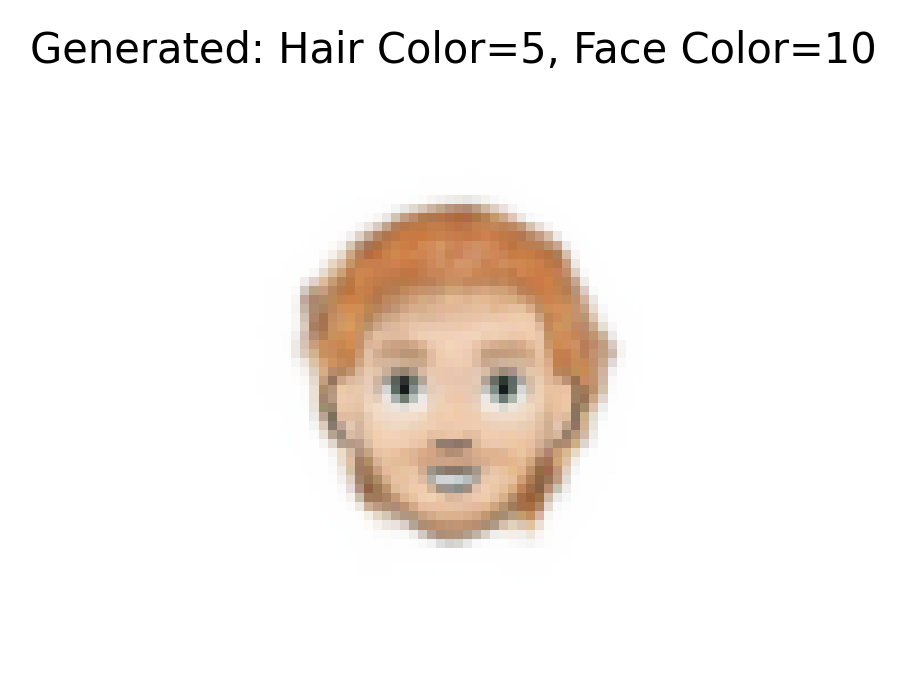

In [61]:
# Conditional generation
# Desired attributes: Hair = class 5, Face = class 10
# The function expects a LIST [5, 10]
target_classes = [5, 10]

x_gen_cond = generate_conditional(model, target_classes, device=DEVICE)

show_tensor_image(
    x_gen_cond,
    title=f"Generated: Hair Color={target_classes[0]}, Face Color={target_classes[1]}",
)


## Visualizations and tests

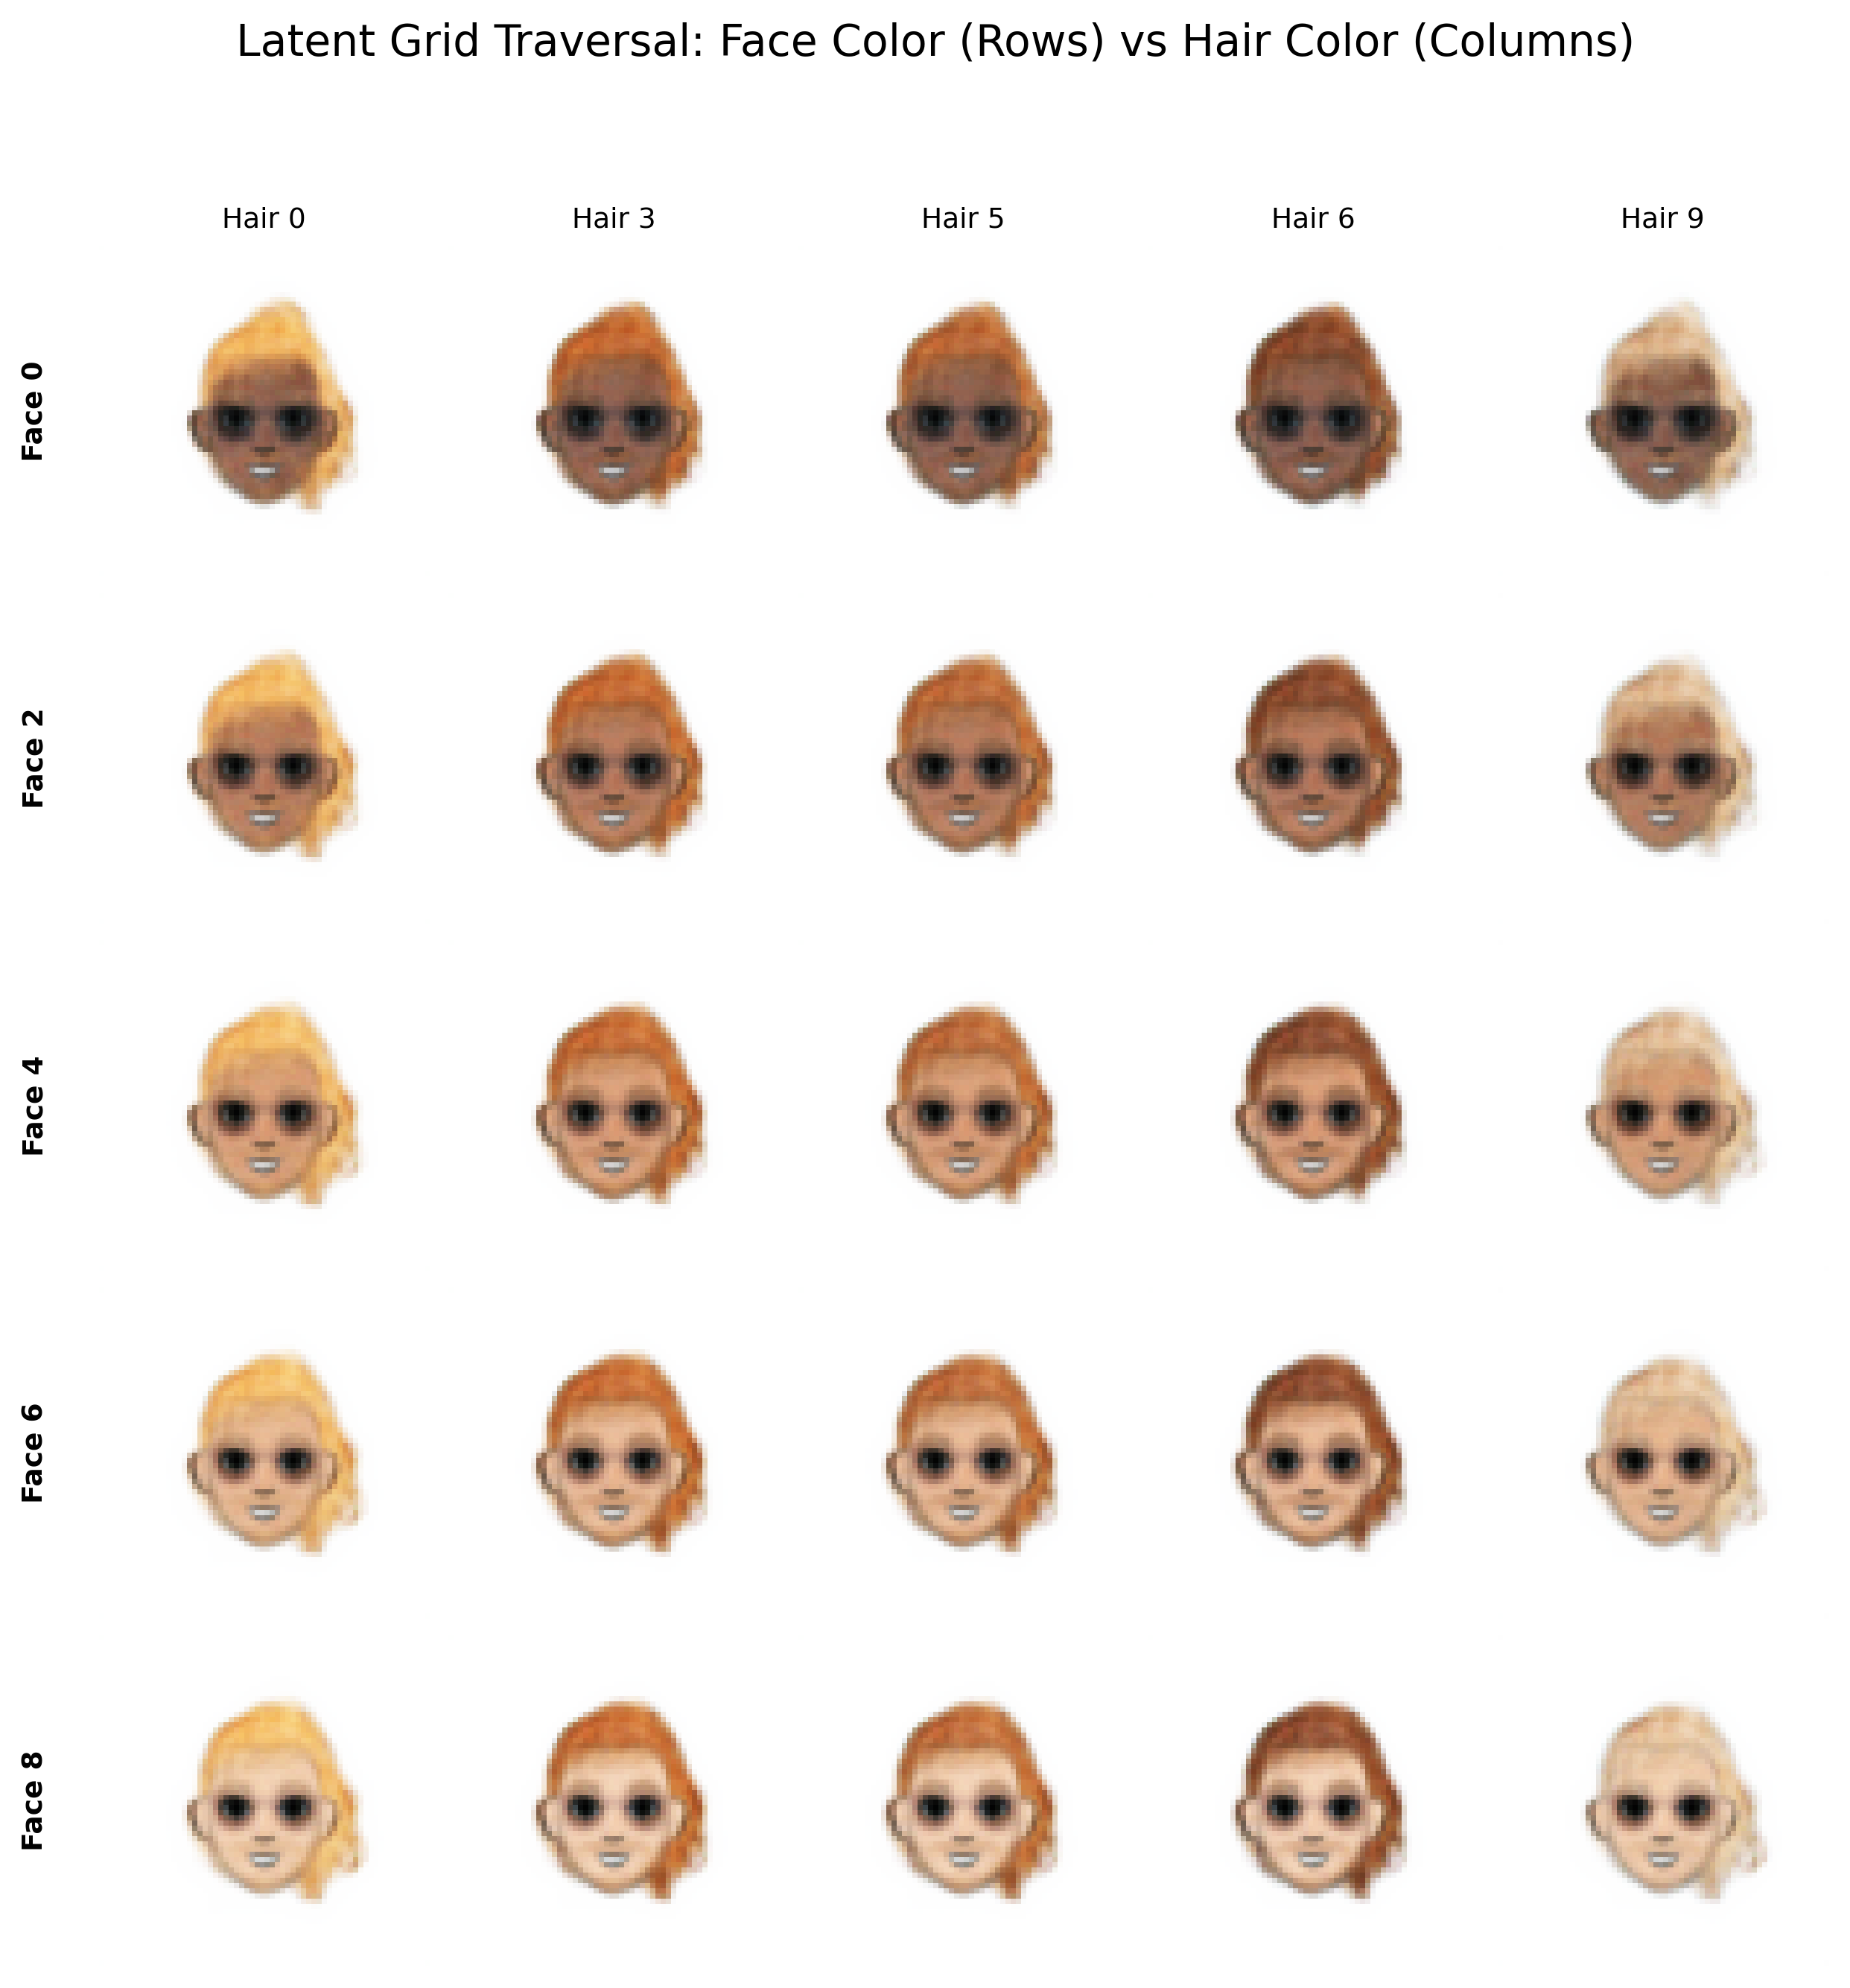

In [63]:
def plot_latent_grid(
    model,
    hair_indices,
    face_indices,
    fixed_z_not_c=None,
    device="cuda",
):
    """
    Generate a grid of images illustrating latent traversals.

    - Columns: variation of hair_color (according to hair_indices)
    - Rows:    variation of face_color (according to face_indices)
    - The nuisance / style latent z_not_c is kept fixed to isolate attribute effects.

    Args:
        model (CCVAE): Trained multi-attribute CCVAE model
        hair_indices (list[int]): Indices of hair color classes (columns)
        face_indices (list[int]): Indices of face color classes (rows)
        fixed_z_not_c (Tensor, optional): Fixed nuisance latent of shape (1, z_not_c_dim).
                                          If None, a random style latent is sampled.
        device (str): Computation device
    """
    model.eval()

    # If no fixed style is provided, sample a random nuisance latent
    if fixed_z_not_c is None:
        fixed_z_not_c = torch.randn(1, model.z_not_c_dim, device=device)
    else:
        fixed_z_not_c = fixed_z_not_c.to(device)
        if fixed_z_not_c.dim() == 1:
            fixed_z_not_c = fixed_z_not_c.unsqueeze(0)

    nrows = len(face_indices)
    ncols = len(hair_indices)

    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(2.0 * ncols, 2.0 * nrows),
        dpi=300,
    )
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    fig.suptitle(
        "Latent Grid Traversal: Face Color (Rows) vs Hair Color (Columns)",
        fontsize=14,
    )

    with torch.no_grad():
        for row_idx, face_idx in enumerate(face_indices):
            for col_idx, hair_idx in enumerate(hair_indices):

                # --------------------------------------------------
                # Construct latent vector z = [z_c_hair, z_c_face, z_not_c]
                # --------------------------------------------------
                z_parts = []

                # Hair color latent (attribute index 0)
                y_hair = torch.tensor([hair_idx], device=device)
                y_hair_onehot = F.one_hot(
                    y_hair,
                    num_classes=model.num_classes_list[0],
                ).float()
                emb_hair = F.relu(model.prior_embeddings[0](y_hair_onehot))
                z_c_hair = model.prior_mu[0](emb_hair)
                z_parts.append(z_c_hair)

                # Face color latent (attribute index 1)
                y_face = torch.tensor([face_idx], device=device)
                y_face_onehot = F.one_hot(
                    y_face,
                    num_classes=model.num_classes_list[1],
                ).float()
                emb_face = F.relu(model.prior_embeddings[1](y_face_onehot))
                z_c_face = model.prior_mu[1](emb_face)
                z_parts.append(z_c_face)

                # Fixed nuisance / style latent
                z_parts.append(fixed_z_not_c)

                # Concatenate and decode
                z = torch.cat(z_parts, dim=1)
                dec_in = model.decoder_input(z).view(-1, 64, 4, 4)
                recon = model.decoder_conv(dec_in)

                # --------------------------------------------------
                # Visualization
                # --------------------------------------------------
                if nrows == 1 and ncols == 1:
                    ax = axes
                elif nrows == 1:
                    ax = axes[col_idx]
                elif ncols == 1:
                    ax = axes[row_idx]
                else:
                    ax = axes[row_idx, col_idx]

                img = recon.squeeze(0).cpu().permute(1, 2, 0).numpy()
                img = np.clip(img, 0.0, 1.0)

                ax.imshow(img)
                ax.axis("off")

                if row_idx == 0:
                    ax.set_title(f"Hair {hair_idx}", fontsize=9)

                if col_idx == 0:
                    ax.text(
                        -0.15,
                        0.5,
                        f"Face {face_idx}",
                        transform=ax.transAxes,
                        va="center",
                        ha="right",
                        rotation=90,
                        fontsize=9,
                        fontweight="bold",
                    )

    plt.show()


# =========================================================
# Example usage
# =========================================================

# Select subsets of attribute indices to visualize
hair_selection = [0, 3, 5, 6, 9]
face_selection = [0, 2, 4, 6, 8]

# Extract a fixed nuisance / style latent from a real image
x_real, _ = dataset[12]
x_real = x_real.unsqueeze(0).to(DEVICE)
_, _, z_style_real = encode_to_z(model, x_real)

# Run latent grid traversal with fixed style
plot_latent_grid(
    model,
    hair_indices=hair_selection,
    face_indices=face_selection,
    fixed_z_not_c=z_style_real,
    device=DEVICE,
)


Generating samples for intervention-based confusion matrix: Hair Color...


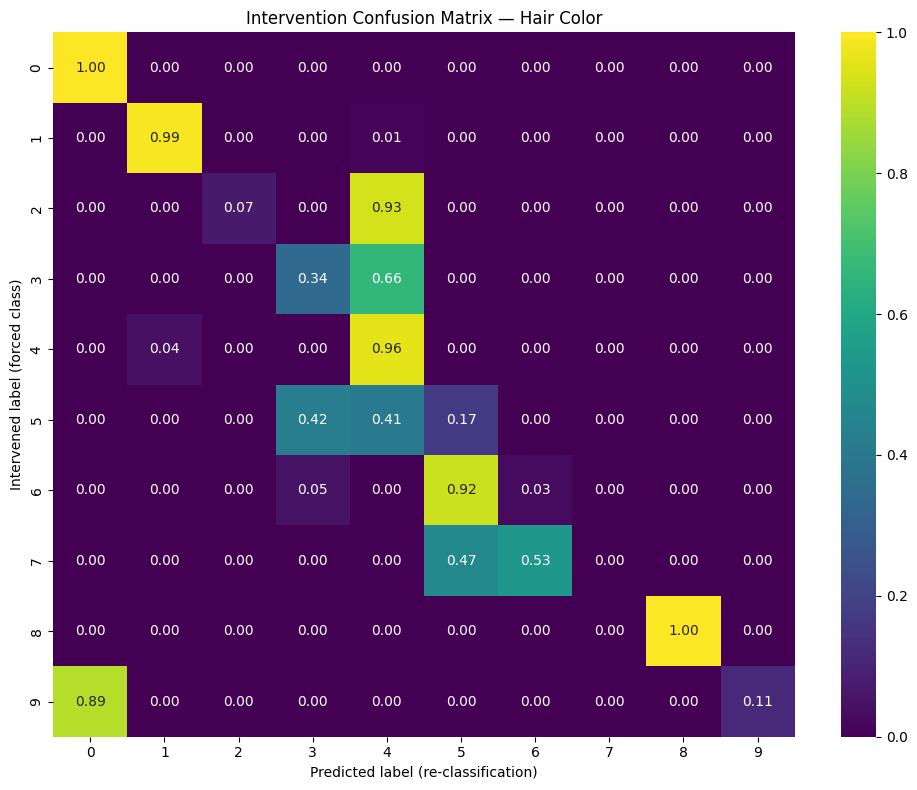

Generating samples for intervention-based confusion matrix: Face Color...


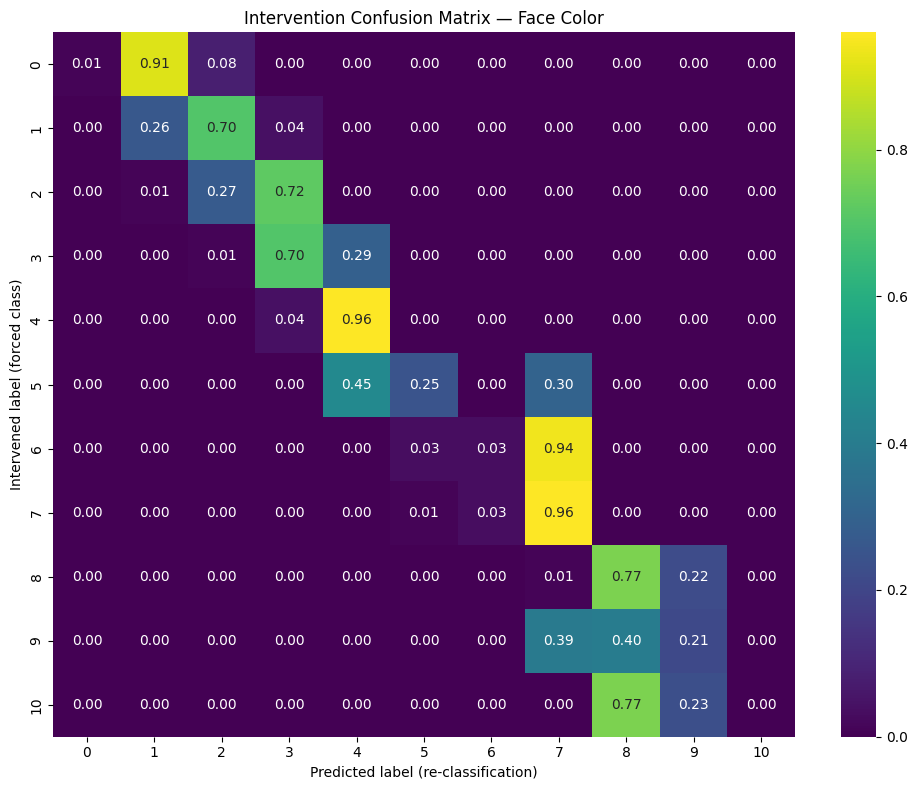

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_intervention_confusion_matrix(
    model,
    attribute_index,
    attribute_name,
    device="cuda",
):
    """
    Plot an intervention-based confusion matrix for a given attribute.

    The procedure follows a causal intervention protocol:
    for each class y_i of a given attribute, we intervene by forcing
    z_{c,i} to follow the corresponding conditional prior p(z_{c,i} | y_i),
    generate images, and then re-classify them using the model.
    The confusion matrix measures how well the intervention is preserved
    after generation.

    Args:
        model (CCVAE): Trained multi-attribute CCVAE model
        attribute_index (int): Index of the attribute to evaluate
                               (e.g., 0 = hair color, 1 = face color)
        attribute_name (str): Human-readable name of the attribute
        device (str): Computation device
    """
    model.eval()
    num_classes = model.num_classes_list[attribute_index]

    y_true = []  # Intervened (target) labels
    y_pred = []  # Re-classified labels

    print(
        f"Generating samples for intervention-based confusion matrix: "
        f"{attribute_name}..."
    )

    with torch.no_grad():
        for class_idx in range(num_classes):
            batch_size = 100

            # --------------------------------------------------
            # Construct latent vectors under intervention
            # --------------------------------------------------
            z_parts = []

            for i in range(model.num_attributes):
                if i == attribute_index:
                    # Intervened attribute: force class = class_idx
                    target_y = torch.full(
                        (batch_size,),
                        class_idx,
                        dtype=torch.long,
                        device=device,
                    )
                    y_onehot = F.one_hot(
                        target_y,
                        num_classes=model.num_classes_list[i],
                    ).float()

                    embed = F.relu(model.prior_embeddings[i](y_onehot))
                    mu_prior = model.prior_mu[i](embed)
                    z_parts.append(mu_prior)
                else:
                    # Other attributes: sample random classes
                    rand_y = torch.randint(
                        0,
                        model.num_classes_list[i],
                        (batch_size,),
                        device=device,
                    )
                    y_onehot = F.one_hot(
                        rand_y,
                        num_classes=model.num_classes_list[i],
                    ).float()

                    embed = F.relu(model.prior_embeddings[i](y_onehot))
                    mu_prior = model.prior_mu[i](embed)
                    z_parts.append(mu_prior)

            # Random nuisance / style latent
            z_not_c = torch.randn(
                batch_size,
                model.z_not_c_dim,
                device=device,
            )
            z_parts.append(z_not_c)

            # --------------------------------------------------
            # Image generation
            # --------------------------------------------------
            z = torch.cat(z_parts, dim=1)
            dec = model.decoder_input(z).view(-1, 64, 4, 4)
            x_gen = model.decoder_conv(dec)

            # --------------------------------------------------
            # Re-classification of generated images
            # --------------------------------------------------
            _, _, _, logits_list, _, _ = model(x_gen)
            preds = torch.argmax(
                logits_list[attribute_index],
                dim=1,
            )

            y_true.extend([class_idx] * batch_size)
            y_pred.extend(preds.cpu().numpy())

    # --------------------------------------------------
    # Confusion matrix (row-normalized)
    # --------------------------------------------------
    cm = confusion_matrix(
        y_true,
        y_pred,
        normalize="true",
    )

    # --------------------------------------------------
    # Visualization
    # --------------------------------------------------
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        xticklabels=range(num_classes),
        yticklabels=range(num_classes),
    )
    plt.xlabel("Predicted label (re-classification)")
    plt.ylabel("Intervened label (forced class)")
    plt.title(f"Intervention Confusion Matrix — {attribute_name}")
    plt.tight_layout()
    plt.show()

# Hair color (attribute index 0)
plot_intervention_confusion_matrix(
    model,
    attribute_index=0,
    attribute_name="Hair Color",
    device=DEVICE,
)

# Face color (attribute index 1)
plot_intervention_confusion_matrix(
    model,
    attribute_index=1,
    attribute_name="Face Color",
    device=DEVICE,
)


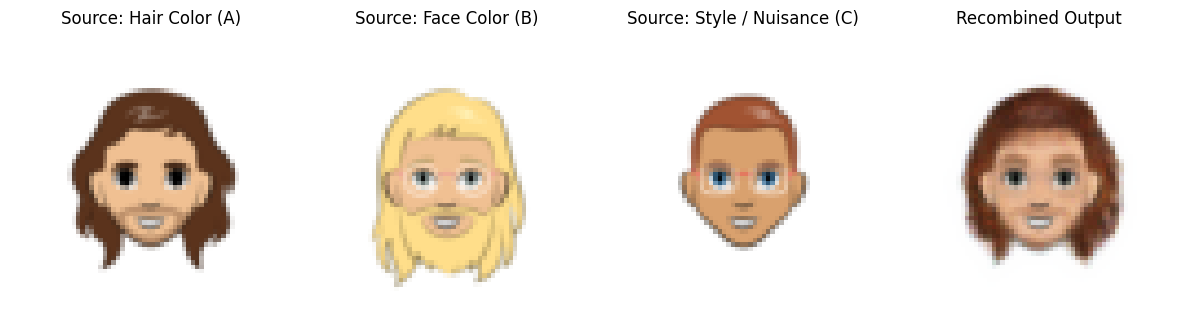

In [ ]:
def mix_and_match_3way(model, dataset, device="cuda"):
    """
    Three-way latent factor recombination experiment.

    This experiment selects three random images from the dataset and
    recombines their latent factors to assess disentanglement:

        - Hair color is taken from image A
        - Face / skin color is taken from image B
        - Nuisance / style latent z_not_c is taken from image C

    The resulting image tests whether attribute-specific latents
    can be independently manipulated while preserving the remaining
    factors of variation.
    """
    model.eval()

    # Randomly sample three images from the dataset
    indices = torch.randperm(len(dataset))[:3]

    img_A, _ = dataset[indices[0]]  # Hair color source
    img_B, _ = dataset[indices[1]]  # Face / skin color source
    img_C, _ = dataset[indices[2]]  # Style / nuisance source

    # Add batch dimension and move to device
    img_A = img_A.unsqueeze(0).to(device)
    img_B = img_B.unsqueeze(0).to(device)
    img_C = img_C.unsqueeze(0).to(device)

    with torch.no_grad():
        # Encode images into latent space
        _, z_c_list_A, _ = encode_to_z(model, img_A)
        _, z_c_list_B, _ = encode_to_z(model, img_B)
        _, _, z_not_c_C = encode_to_z(model, img_C)

        # Latent recombination:
        # z = [z_c_hair(A), z_c_face(B), z_not_c(C)]
        z_mix = torch.cat(
            [
                z_c_list_A[0],  # Hair color from A
                z_c_list_B[1],  # Face color from B
                z_not_c_C,      # Style from C
            ],
            dim=1,
        )

        # Decode mixed latent representation
        dec = model.decoder_input(z_mix).view(-1, 64, 4, 4)
        x_mix = model.decoder_conv(dec)

    images = [img_A, img_B, img_C, x_mix]
    titles = [
        "Source: Hair Color (A)",
        "Source: Face Color (B)",
        "Source: Style / Nuisance (C)",
        "Recombined Output",
    ]

    plt.figure(figsize=(12, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 4, i + 1)
        img_np = img.squeeze(0).cpu().permute(1, 2, 0).numpy()
        plt.imshow(np.clip(img_np, 0, 1))
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

mix_and_match_3way(model, dataset, device=DEVICE)


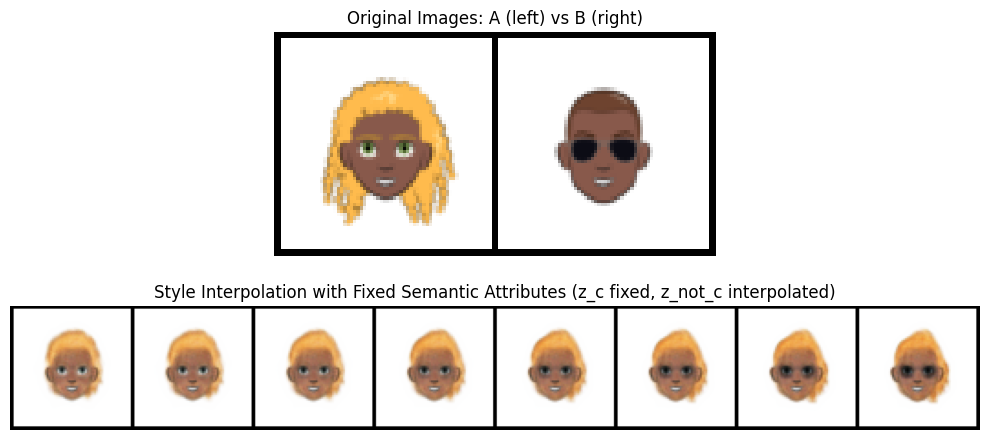

In [ ]:
def interpolate_style(model, dataset, device="cuda", steps=8):
    """
    Style interpolation experiment with fixed semantic attributes.

    This experiment evaluates disentanglement between semantic attributes
    (z_c: hair color, face/skin color) and nuisance/style factors (z_not_c).

    Two images A and B are sampled from the dataset:
      - Semantic attributes (hair color, face color) are fixed to those of image A
      - The style latent z_not_c is linearly interpolated from A to B

    The resulting images should preserve the semantic attributes of A
    while smoothly transitioning in style from A to B.
    """
    model.eval()

    # --------------------------------------------------
    # Sample two images from the dataset
    # --------------------------------------------------
    idx1, idx2 = torch.randperm(len(dataset))[:2]

    img1, label1 = dataset[idx1]  # label1 = [hair_idx, face_idx] for image A
    img2, _ = dataset[idx2]

    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    with torch.no_grad():
        # --------------------------------------------------
        # Extract style latents z_not_c from both images
        # --------------------------------------------------
        _, _, z_style_1 = encode_to_z(model, img1)
        _, _, z_style_2 = encode_to_z(model, img2)

        # --------------------------------------------------
        # Fix semantic attributes to those of image A
        # --------------------------------------------------
        target_hair = label1[0].item()
        target_face = label1[1].item()

        # Hair color latent from conditional prior
        y_hair = F.one_hot(
            torch.tensor([target_hair], device=device),
            num_classes=model.num_classes_list[0],
        ).float()
        z_hair = model.prior_mu[0](
            F.relu(model.prior_embeddings[0](y_hair))
        )

        # Face / skin color latent from conditional prior
        y_face = F.one_hot(
            torch.tensor([target_face], device=device),
            num_classes=model.num_classes_list[1],
        ).float()
        z_face = model.prior_mu[1](
            F.relu(model.prior_embeddings[1](y_face))
        )

        # --------------------------------------------------
        # Linear interpolation in style space
        # --------------------------------------------------
        alphas = np.linspace(0.0, 1.0, steps)
        interpolated_imgs = []

        for alpha in alphas:
            # Interpolate style from image A to image B
            z_style_interp = (1.0 - alpha) * z_style_1 + alpha * z_style_2

            # Concatenate fixed semantic latents with interpolated style
            z = torch.cat([z_hair, z_face, z_style_interp], dim=1)

            dec = model.decoder_input(z).view(-1, 64, 4, 4)
            img = model.decoder_conv(dec)
            interpolated_imgs.append(img)
    plt.figure(figsize=(10, 5))

    # Top row: original images A and B
    plt.subplot(2, 1, 1)
    grid_src = make_grid(torch.cat([img1, img2], dim=0), nrow=2)
    plt.imshow(grid_src.cpu().permute(1, 2, 0).numpy())
    plt.title("Original Images: A (left) vs B (right)")
    plt.axis("off")

    # Bottom row: style interpolation with fixed semantics
    plt.subplot(2, 1, 2)
    grid_interp = make_grid(torch.cat(interpolated_imgs, dim=0), nrow=steps)
    plt.imshow(grid_interp.cpu().permute(1, 2, 0).numpy())
    plt.title(
        "Style Interpolation with Fixed Semantic Attributes "
        "(z_c fixed, z_not_c interpolated)"
    )
    plt.axis("off")

    plt.tight_layout()
    plt.show()

interpolate_style(model, dataset, device=DEVICE)


## Probing experiments

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import xgboost as xgb

def run_glasses_probe(probe_dataset,model, data_dir, device='cuda', sample_limit=2000, use_xgboost=False):
    print(f"--- Starting Probe: Unsupervised Glasses Detection (Mode: {'XGBoost' if use_xgboost else 'Logistic Regression'}) ---")
    
    probe_loader = DataLoader(probe_dataset, batch_size=64, shuffle=True)
    
    print(f"Extracting latent vectors from {sample_limit} images...")
    
    X_style = []      # z_not_c (Unsupervised Style)
    X_content = []    # z_c (Supervised Color)
    y_ground_truth = []  # True Label: Wearing Glasses (1) or Not (0)
    
    model.eval()
    samples_collected = 0
    
    with torch.no_grad():
        for x, labels in probe_loader:
            x = x.to(device)
            
            # labels shape is [Batch, 3] -> [hair, face, glasses]
            # Column 2 is "glasses"
            glasses_indices = labels[:, 2].cpu().numpy()
            
            # 2. Define the Target
            # User info: Class 11 means "No Glasses". 
            # Logic: If index is NOT 11, then they ARE wearing glasses (1).
            is_wearing_glasses = (glasses_indices != 11).astype(int)
            
            # 3. Extract Latents
            # We use the 'encode_to_z' function defined in your previous block
            _, z_c_list, z_not_c = encode_to_z(model, x)
            
            # z_not_c is the style (1, 32)
            # z_c_list is [hair(16), face(16)]. We concat them to see if ANY color info leaked.
            z_c_concat = torch.cat(z_c_list, dim=1).cpu().numpy()
            
            X_style.append(z_not_c.cpu().numpy())
            X_content.append(z_c_concat)
            y_ground_truth.append(is_wearing_glasses)
            
            samples_collected += x.size(0)
            if samples_collected >= sample_limit:
                break
    
    # Concatenate lists into numpy arrays
    X_style = np.concatenate(X_style)[:samples_collected]
    X_content = np.concatenate(X_content)[:samples_collected]
    y_ground_truth = np.concatenate(y_ground_truth)[:samples_collected]
    
    print(f"Data extracted: {len(y_ground_truth)} samples.")
    print(f"Glasses prevalence: {y_ground_truth.mean():.1%}")

    # 4. Train Probes
    print("\nTraining Classifiers...")
    
    # Helper to train and evaluate
    def train_evaluate(X, y, name):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        if use_xgboost:
            # clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
            clf = xgb.XGBClassifier(eval_metric='logloss')
        else:
            clf = LogisticRegression(max_iter=1000, class_weight='balanced')
            
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        return acc, clf

    # --- Probe A: Style Vector (z_not_c) ---
    acc_style, clf_style = train_evaluate(X_style, y_ground_truth, "Style")
    
    # --- Probe B: Color Vector (z_c) - Control ---
    acc_content, _ = train_evaluate(X_content, y_ground_truth, "Color")
    
    # 5. Report Results
    print("\n" + "="*40)
    print("ROBE RESULTS")
    print("="*40)
    print(f"Feature: GLASSES")
    print(f"Model: {'XGBoost (Non-linear)' if use_xgboost else 'Logistic Regression (Linear)'}")
    print(f"----------------------------------------")
    print(f"Accuracy on Style Vector (z_not_c):   {acc_style:.2%}")
    print(f"Accuracy on Color Vector (z_c):       {acc_content:.2%}")
    print("="*40)
    
    results = {
        'Style': acc_style,
        'Color': acc_content
    }
    
    return clf_style,results

# 1. Setup a specific Probe Dataset
# We MUST reload the dataset to get the "glasses" attribute from the CSVs.
print("Lazy loading dataset metadata for probe...")
probe_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# We request "glasses" specifically
probe_dataset = CartoonMultiLabelDataset(
    root_dir=DATA_DIR, 
    target_attributes=["hair_color", "face_color", "glasses"], 
    transform=probe_transform
)
# --- RUN EXPERIMENT ---
# 1. Linear Probe (Good for surgery)
linear_clf,res_linear = run_glasses_probe(probe_dataset,model, DATA_DIR, DEVICE, sample_limit=2000, use_xgboost=False)

# 2. Non-Linear Probe (Good for checking max capacity)
xgb_clf,res_xgb = run_glasses_probe(probe_dataset,model, DATA_DIR, DEVICE, sample_limit=2000, use_xgboost=True)

Lazy loading dataset metadata for probe...
Loading labels for attributes: ['hair_color', 'face_color', 'glasses'] ...
Dataset loaded successfully. Attribute dimensions: {'hair_color': 10, 'face_color': 11, 'glasses': 12}
--- Starting Probe: Unsupervised Glasses Detection (Mode: Logistic Regression) ---
Extracting latent vectors from 2000 images...
Data extracted: 2048 samples.
Glasses prevalence: 50.1%

Training Classifiers...

ROBE RESULTS
Feature: GLASSES
Model: Logistic Regression (Linear)
----------------------------------------
Accuracy on Style Vector (z_not_c):   66.83%
Accuracy on Color Vector (z_c):       67.80%
--- Starting Probe: Unsupervised Glasses Detection (Mode: XGBoost) ---
Extracting latent vectors from 2000 images...
Data extracted: 2048 samples.
Glasses prevalence: 48.8%

Training Classifiers...

ROBE RESULTS
Feature: GLASSES
Model: XGBoost (Non-linear)
----------------------------------------
Accuracy on Style Vector (z_not_c):   66.83%
Accuracy on Color Vector (z_

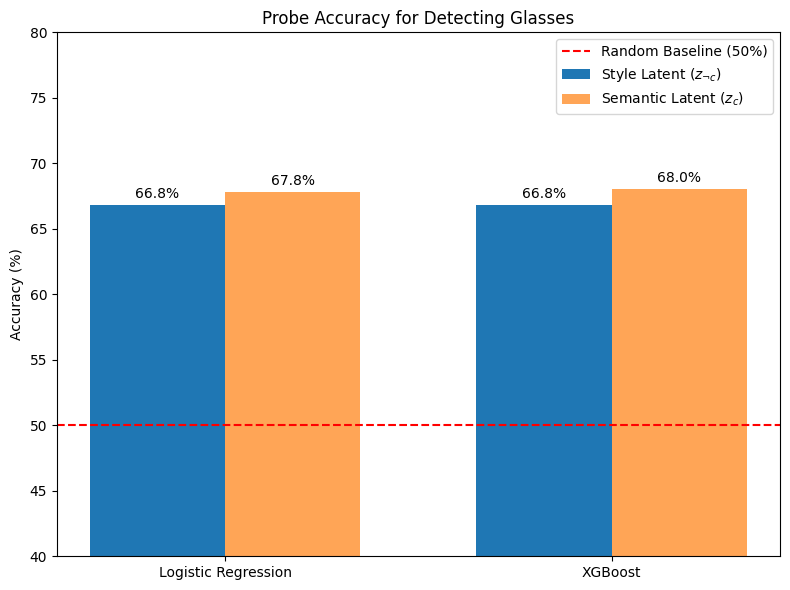

In [68]:
def plot_probe_results(results_dict):
    """
    Visualization of linear and non-linear probe results.

    This plot compares the predictive performance of probes trained on:
      - the nuisance/style latent vector z_{¬c}
      - the semantic/color latent vector z_c

    The goal is to assess whether a non-target attribute (e.g. glasses)
    leaks into the semantic or nuisance subspaces.
    """
    model_names = list(results_dict.keys())  # e.g. ['Logistic Regression', 'XGBoost']
    style_scores = [results_dict[m]["Style"] * 100.0 for m in model_names]
    color_scores = [results_dict[m]["Color"] * 100.0 for m in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 6))

    bars_style = ax.bar(
        x - width / 2,
        style_scores,
        width,
        label=r"Style Latent ($z_{\neg c}$)",
        color="#1f77b4",
    )
    bars_color = ax.bar(
        x + width / 2,
        color_scores,
        width,
        label=r"Semantic Latent ($z_c$)",
        color="#ff7f0e",
        alpha=0.7,
    )

    # Random-guess baseline (binary attribute)
    ax.axhline(
        y=50.0,
        color="red",
        linestyle="--",
        label="Random Baseline (50%)",
    )

    ax.set_ylabel("Accuracy (%)")
    ax.set_title("Probe Accuracy for Detecting Glasses")
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylim(40, 80)
    ax.legend()

    # Annotate bars with numerical values
    def annotate_bars(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f"{height:.1f}%",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    annotate_bars(bars_style)
    annotate_bars(bars_color)

    fig.tight_layout()
    plt.show()

all_results = {
    "Logistic Regression": res_linear,
    "XGBoost": res_xgb,
}

plot_probe_results(all_results)


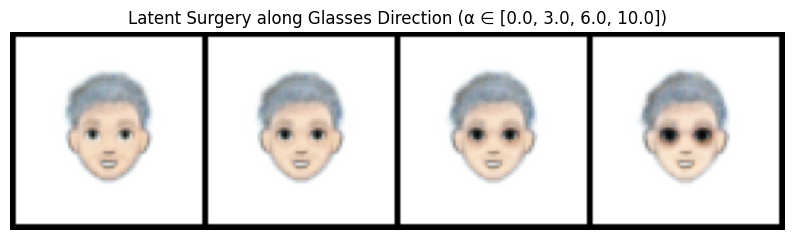

In [69]:
def latent_surgery(model, clf, data_loader, device="cuda"):
    """
    Latent space intervention via linear probe directions.

    This experiment applies a controlled intervention along the
    "glasses" direction learned by a linear classifier trained on
    the nuisance latent z_{¬c}. The goal is to assess whether adding
    this direction induces the targeted attribute while preserving
    semantic content.
    """
    model.eval()

    # Direction corresponding to the "glasses" attribute
    glasses_vector = torch.tensor(clf.coef_[0], dtype=torch.float32).to(device)
    glasses_vector = glasses_vector / torch.norm(glasses_vector)

    # Select an image without glasses
    target_img = None
    with torch.no_grad():
        for x, labels in data_loader:
            no_glasses_mask = labels[:, 2] == 11  # class index for "no glasses"
            if no_glasses_mask.any():
                target_img = x[no_glasses_mask][:1].to(device)
                break

    if target_img is None:
        print("No image without glasses found.")
        return

    # Encode image
    _, z_c_list, z_not_c = encode_to_z(model, target_img)

    # Apply latent intervention with increasing strength
    alphas = [0.0, 3.0, 6.0, 10.0]
    generated = []

    with torch.no_grad():
        for alpha in alphas:
            z_not_c_mod = z_not_c + alpha * glasses_vector
            z_full = torch.cat(list(z_c_list) + [z_not_c_mod], dim=1)

            dec = model.decoder_input(z_full).view(-1, 64, 4, 4)
            img = model.decoder_conv(dec)
            generated.append(img.cpu())

    # Visualization
    grid = make_grid(torch.cat(generated), nrow=len(alphas), padding=2)
    plt.figure(figsize=(10, 4))
    plt.imshow(grid.permute(1, 2, 0).clamp(0, 1))
    plt.title(f"Latent Surgery along Glasses Direction (α ∈ {alphas})")
    plt.axis("off")
    plt.show()

surgery_loader = DataLoader(probe_dataset, batch_size=32, shuffle=True)
latent_surgery(model, linear_clf, surgery_loader, device=DEVICE)


--- Experiment: Leakage Surgery on Semantic Latent z_c ---
Loading labels for attributes: ['hair_color', 'face_color', 'glasses'] ...
Dataset loaded successfully. Attribute dimensions: {'hair_color': 10, 'face_color': 11, 'glasses': 12}


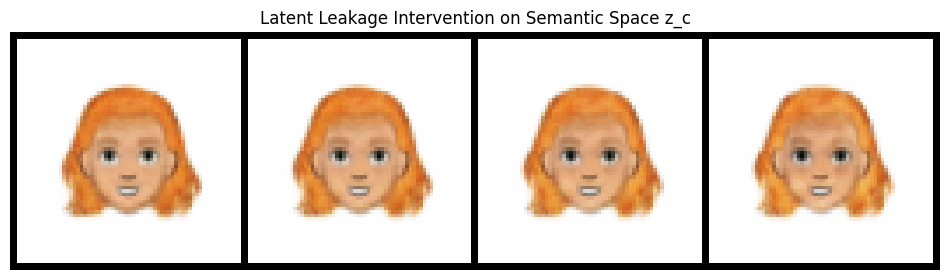

Interpretation:
- Appearance of glasses indicates leakage into z_c.
- Pure color changes indicate effective disentanglement.


In [70]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import transforms


def run_leakage_surgery(model, data_dir, device="cuda", sample_limit=2000):
    """
    Latent leakage intervention on the semantic color space z_c.

    This experiment tests whether a non-target attribute (glasses) is
    spuriously encoded in the semantic latent subspace z_c. A linear
    probe is trained to predict glasses from z_c, and the corresponding
    direction is used to perform a controlled latent intervention.
    """
    print("--- Experiment: Leakage Surgery on Semantic Latent z_c ---")

    # --------------------------------------------------
    # 1. Dataset loading and latent extraction
    # --------------------------------------------------
    probe_transform = transforms.Compose(
        [transforms.Resize((64, 64)), transforms.ToTensor()]
    )

    probe_dataset = CartoonMultiLabelDataset(
        root_dir=data_dir,
        target_attributes=["hair_color", "face_color", "glasses"],
        transform=probe_transform,
    )
    probe_loader = DataLoader(probe_dataset, batch_size=64, shuffle=True)

    X_latent = []
    y_glasses = []

    model.eval()
    samples_collected = 0
    target_img = None

    with torch.no_grad():
        for x, labels in probe_loader:
            x = x.to(device)

            glasses_idx = labels[:, 2].cpu().numpy()
            glasses_binary = (glasses_idx != 11).astype(int)

            if target_img is None:
                mask = labels[:, 2] == 11
                if mask.any():
                    target_img = x[mask][:1]

            _, z_c_list, _ = encode_to_z(model, x)
            z_c_concat = torch.cat(list(z_c_list), dim=1).cpu().numpy()

            X_latent.append(z_c_concat)
            y_glasses.append(glasses_binary)

            samples_collected += x.size(0)
            if samples_collected >= sample_limit:
                break

    if target_img is None:
        print("Error: no image without glasses found.")
        return

    X = np.concatenate(X_latent)[:samples_collected]
    y = np.concatenate(y_glasses)[:samples_collected]

    # --------------------------------------------------
    # 2. Linear probe training
    # --------------------------------------------------
    clf = LogisticRegression(max_iter=1000, class_weight="balanced")
    clf.fit(X, y)

    glasses_direction = torch.tensor(
        clf.coef_[0], dtype=torch.float32, device=device
    )
    glasses_direction = glasses_direction / torch.norm(glasses_direction)

    # --------------------------------------------------
    # 3. Latent intervention
    # --------------------------------------------------
    _, z_c_list, z_not_c = encode_to_z(model, target_img)

    alphas = [0.0, 5.0, 10.0, 15.0]
    generated = []

    for alpha in alphas:
        z_c_concat = torch.cat(list(z_c_list), dim=1)
        z_c_modified = z_c_concat + alpha * glasses_direction

        z_c_split = torch.split(z_c_modified, [16, 16], dim=1)
        z_full = torch.cat(list(z_c_split) + [z_not_c], dim=1)

        dec = model.decoder_input(z_full).view(-1, 64, 4, 4)
        img = model.decoder_conv(dec)
        generated.append(img.cpu())

    # --------------------------------------------------
    # 4. Visualization
    # --------------------------------------------------
    grid = make_grid(torch.cat(generated), nrow=len(alphas), padding=2)
    plt.figure(figsize=(12, 5))
    plt.imshow(grid.permute(1, 2, 0).clamp(0, 1))
    plt.title("Latent Leakage Intervention on Semantic Space z_c")
    plt.axis("off")
    plt.show()

    print("Interpretation:")
    print("- Appearance of glasses indicates leakage into z_c.")
    print("- Pure color changes indicate effective disentanglement.")


# Example usage
run_leakage_surgery(model, DATA_DIR, device=DEVICE)


=== Experiment: Latent Correlation Heatmap ===
Loading labels for attributes: ['chin_length', 'eye_angle', 'eye_lashes', 'eye_lid', 'eyebrow_weight', 'eyebrow_thickness', 'face_shape', 'eye_slant', 'eyebrow_width', 'eye_eyebrow_distance'] ...
Dataset loaded successfully. Attribute dimensions: {'chin_length': 3, 'eye_angle': 3, 'eye_lashes': 2, 'eye_lid': 2, 'eyebrow_weight': 2, 'eyebrow_thickness': 4, 'face_shape': 7, 'eye_slant': 3, 'eyebrow_width': 3, 'eye_eyebrow_distance': 3}


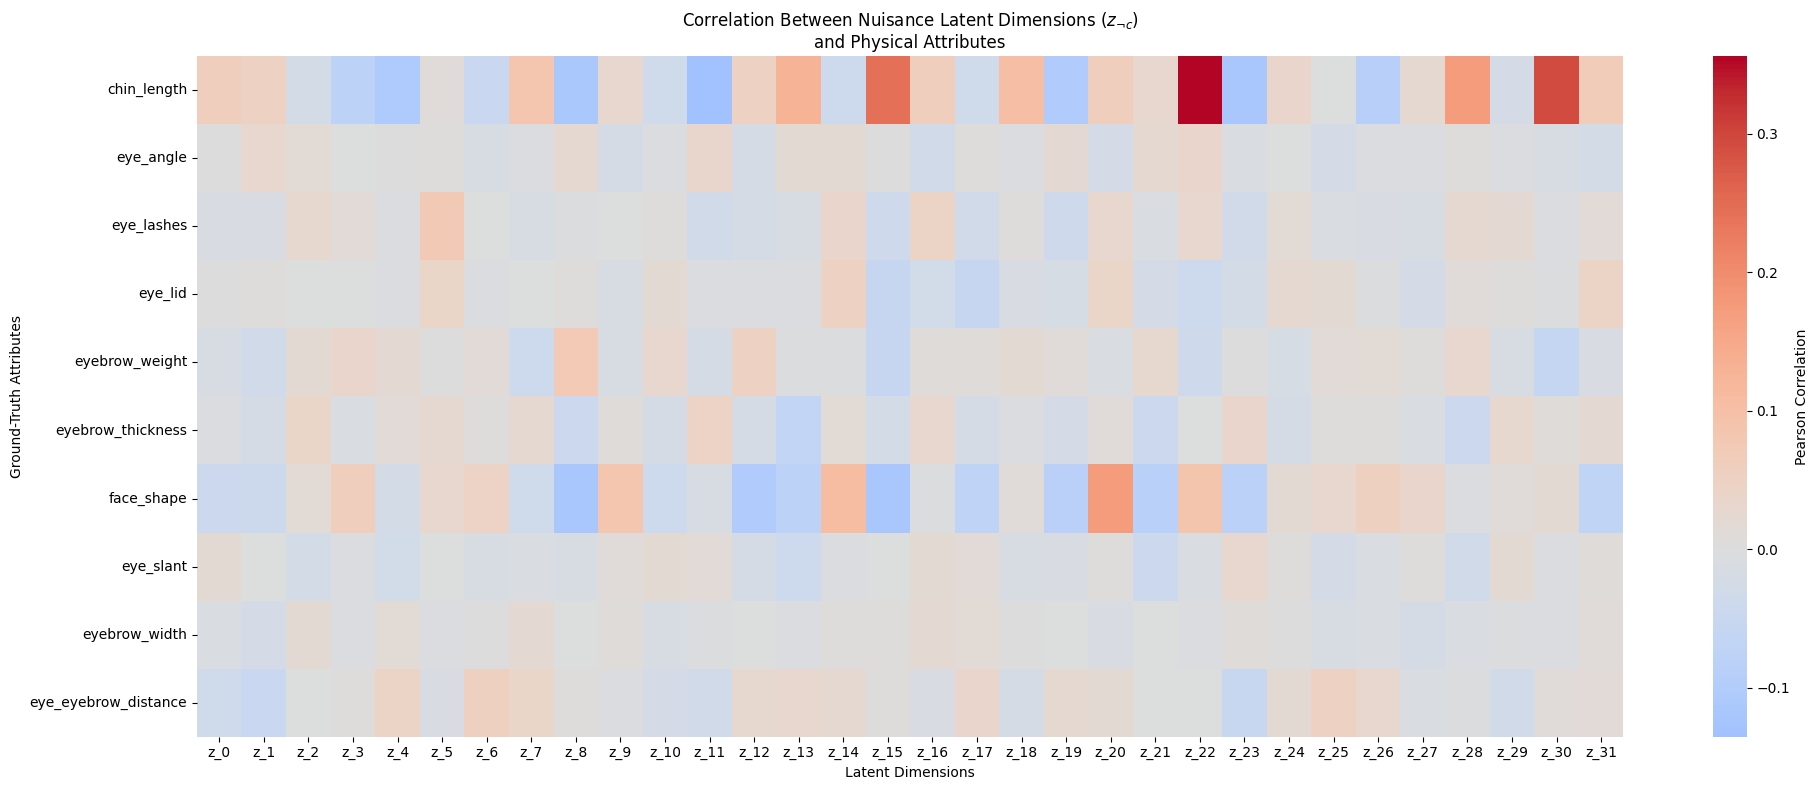

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def experiment_latent_correlation(
    model,
    data_dir,
    device="cuda",
    sample_limit=2000,
):
    """
    Correlation analysis between nuisance latent dimensions z_{¬c}
    and continuous / ordinal ground-truth attributes.

    This experiment evaluates whether unsupervised latent neurons
    encode interpretable physical attributes by measuring Pearson
    correlations between z_{¬c} and selected attributes.
    """
    print("=== Experiment: Latent Correlation Heatmap ===")

    # Attributes of interest
    interesting_attributes = [
        "chin_length",
        "eye_angle",
        "eye_lashes",
        "eye_lid",
        "eyebrow_weight",
        "eyebrow_thickness",
        "face_shape",
        "eye_slant",
        "eyebrow_width",
        "eye_eyebrow_distance",
    ]

    probe_transform = transforms.Compose(
        [transforms.Resize((64, 64)), transforms.ToTensor()]
    )

    probe_dataset = CartoonMultiLabelDataset(
        root_dir=data_dir,
        target_attributes=interesting_attributes,
        transform=probe_transform,
    )
    probe_loader = DataLoader(probe_dataset, batch_size=64, shuffle=True)

    latent_vectors = []
    attribute_vectors = []

    model.eval()
    samples_collected = 0

    with torch.no_grad():
        for x, labels in probe_loader:
            x = x.to(device)

            _, _, z_not_c = encode_to_z(model, x)
            latent_vectors.append(z_not_c.cpu().numpy())
            attribute_vectors.append(labels.cpu().numpy())

            samples_collected += x.size(0)
            if samples_collected >= sample_limit:
                break

    Z = np.concatenate(latent_vectors)[:samples_collected]
    A = np.concatenate(attribute_vectors)[:samples_collected]

    z_columns = [f"z_{i}" for i in range(Z.shape[1])]
    df_z = pd.DataFrame(Z, columns=z_columns)
    df_attr = pd.DataFrame(A, columns=interesting_attributes)

    full_df = pd.concat([df_z, df_attr], axis=1)
    corr = full_df.corr()

    cross_corr = corr.loc[interesting_attributes, z_columns]

    # Visualization
    plt.figure(figsize=(20, 8))
    sns.heatmap(
        cross_corr,
        cmap="coolwarm",
        center=0.0,
        cbar_kws={"label": "Pearson Correlation"},
        annot=False,
    )
    plt.title(
        "Correlation Between Nuisance Latent Dimensions ($z_{\\neg c}$)\n"
        "and Physical Attributes"
    )
    plt.xlabel("Latent Dimensions")
    plt.ylabel("Ground-Truth Attributes")
    plt.tight_layout()
    plt.show()

    return cross_corr


# Example usage
correlation_df = experiment_latent_correlation(model, DATA_DIR, device=DEVICE)


=== Latent Surgery: Chin Length (Neuron 22) ===
Loading labels for attributes: ['hair_color'] ...
Dataset loaded successfully. Attribute dimensions: {'hair_color': 10}


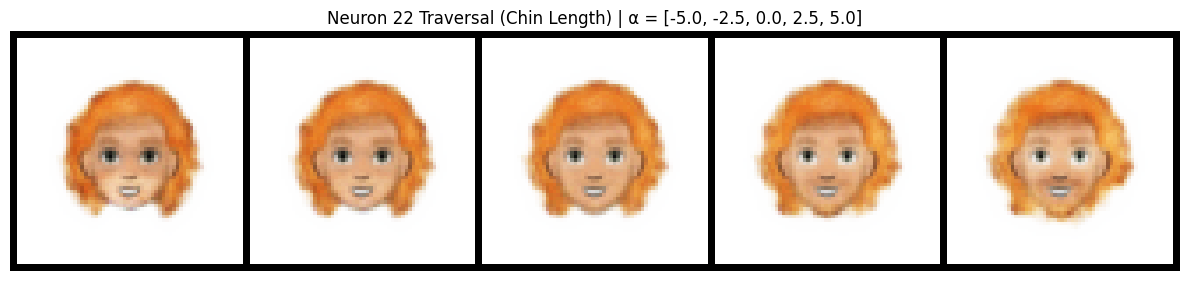

In [72]:
def surgery_chin_length(model, data_dir, device="cuda"):
    """
    Latent surgery along a single nuisance dimension (neuron 22),
    identified as correlated with chin length.
    """
    print("=== Latent Surgery: Chin Length (Neuron 22) ===")

    transform = transforms.Compose(
        [transforms.Resize((64, 64)), transforms.ToTensor()]
    )

    dataset = CartoonMultiLabelDataset(
        root_dir=data_dir,
        target_attributes=["hair_color"],  # minimal loading
        transform=transform,
    )
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Unit direction targeting neuron 22 in z_{¬c}
    feature_vector = torch.zeros((1, model.z_not_c_dim), device=device)
    feature_vector[0, 22] = 1.0

    # Select a reference image
    target_img, _ = next(iter(loader))
    target_img = target_img[0:1].to(device)

    # Encode
    _, z_c_list, z_not_c = encode_to_z(model, target_img)

    # Latent manipulation
    alphas = [-5.0, -2.5, 0.0, 2.5, 5.0]
    results = []

    for alpha in alphas:
        z_not_c_new = z_not_c + alpha * feature_vector
        z_combined = torch.cat(list(z_c_list) + [z_not_c_new], dim=1)

        dec_in = model.decoder_input(z_combined).view(-1, 64, 4, 4)
        recon = model.decoder_conv(dec_in)
        results.append(recon.cpu())

    # Visualization
    grid = make_grid(torch.cat(results), nrow=len(alphas), padding=2)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).clip(0, 1))
    plt.title(f"Neuron 22 Traversal (Chin Length) | α = {alphas}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Example usage
surgery_chin_length(model, DATA_DIR, device=DEVICE)


## Probing experiments

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import xgboost as xgb

def run_glasses_probe(probe_dataset,model, data_dir, device='cuda', sample_limit=2000, use_xgboost=False):
    print(f"--- Starting Probe: Unsupervised Glasses Detection (Mode: {'XGBoost' if use_xgboost else 'Logistic Regression'}) ---")
    
    probe_loader = DataLoader(probe_dataset, batch_size=64, shuffle=True)
    
    print(f"Extracting latent vectors from {sample_limit} images...")
    
    X_style = []      # z_not_c (Unsupervised Style)
    X_content = []    # z_c (Supervised Color)
    y_ground_truth = []  # True Label: Wearing Glasses (1) or Not (0)
    
    model.eval()
    samples_collected = 0
    
    with torch.no_grad():
        for x, labels in probe_loader:
            x = x.to(device)
            
            # labels shape is [Batch, 3] -> [hair, face, glasses]
            # Column 2 is "glasses"
            glasses_indices = labels[:, 2].cpu().numpy()
            
            # 2. Define the Target
            # User info: Class 11 means "No Glasses". 
            # Logic: If index is NOT 11, then they ARE wearing glasses (1).
            is_wearing_glasses = (glasses_indices != 11).astype(int)
            
            # 3. Extract Latents
            # We use the 'encode_to_z' function defined in your previous block
            _, z_c_list, z_not_c = encode_to_z(model, x)
            
            # z_not_c is the style (1, 32)
            # z_c_list is [hair(16), face(16)]. We concat them to see if ANY color info leaked.
            z_c_concat = torch.cat(z_c_list, dim=1).cpu().numpy()
            
            X_style.append(z_not_c.cpu().numpy())
            X_content.append(z_c_concat)
            y_ground_truth.append(is_wearing_glasses)
            
            samples_collected += x.size(0)
            if samples_collected >= sample_limit:
                break
    
    # Concatenate lists into numpy arrays
    X_style = np.concatenate(X_style)[:samples_collected]
    X_content = np.concatenate(X_content)[:samples_collected]
    y_ground_truth = np.concatenate(y_ground_truth)[:samples_collected]
    
    print(f"Data extracted: {len(y_ground_truth)} samples.")
    print(f"Glasses prevalence: {y_ground_truth.mean():.1%}")

    # 4. Train Probes
    print("\nTraining Classifiers...")
    
    # Helper to train and evaluate
    def train_evaluate(X, y, name):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        if use_xgboost:
            # clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
            clf = xgb.XGBClassifier(eval_metric='logloss')
        else:
            clf = LogisticRegression(max_iter=1000, class_weight='balanced')
            
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        return acc, clf

    # --- Probe A: Style Vector (z_not_c) ---
    acc_style, clf_style = train_evaluate(X_style, y_ground_truth, "Style")
    
    # --- Probe B: Color Vector (z_c) - Control ---
    acc_content, _ = train_evaluate(X_content, y_ground_truth, "Color")
    
    # 5. Report Results
    print("\n" + "="*40)
    print("ROBE RESULTS")
    print("="*40)
    print(f"Feature: GLASSES")
    print(f"Model: {'XGBoost (Non-linear)' if use_xgboost else 'Logistic Regression (Linear)'}")
    print(f"----------------------------------------")
    print(f"Accuracy on Style Vector (z_not_c):   {acc_style:.2%}")
    print(f"Accuracy on Color Vector (z_c):       {acc_content:.2%}")
    print("="*40)
    
    results = {
        'Style': acc_style,
        'Color': acc_content
    }
    
    return clf_style,results

# 1. Setup a specific Probe Dataset
# We MUST reload the dataset to get the "glasses" attribute from the CSVs.
print("Lazy loading dataset metadata for probe...")
probe_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# We request "glasses" specifically
probe_dataset = CartoonMultiLabelDataset(
    root_dir=DATA_DIR, 
    target_attributes=["hair_color", "face_color", "glasses"], 
    transform=probe_transform
)
# --- RUN EXPERIMENT ---
# 1. Linear Probe (Good for surgery)
linear_clf,res_linear = run_glasses_probe(probe_dataset,model, DATA_DIR, DEVICE, sample_limit=2000, use_xgboost=False)

# 2. Non-Linear Probe (Good for checking max capacity)
xgb_clf,res_xgb = run_glasses_probe(probe_dataset,model, DATA_DIR, DEVICE, sample_limit=2000, use_xgboost=True)

Lazy loading dataset metadata for probe...
Loading labels for attributes: ['hair_color', 'face_color', 'glasses'] ...
Dataset loaded successfully. Attribute dimensions: {'hair_color': 10, 'face_color': 11, 'glasses': 12}
--- Starting Probe: Unsupervised Glasses Detection (Mode: Logistic Regression) ---
Extracting latent vectors from 2000 images...
Data extracted: 2048 samples.
Glasses prevalence: 50.1%

Training Classifiers...

ROBE RESULTS
Feature: GLASSES
Model: Logistic Regression (Linear)
----------------------------------------
Accuracy on Style Vector (z_not_c):   66.83%
Accuracy on Color Vector (z_c):       67.80%
--- Starting Probe: Unsupervised Glasses Detection (Mode: XGBoost) ---
Extracting latent vectors from 2000 images...
Data extracted: 2048 samples.
Glasses prevalence: 48.8%

Training Classifiers...

ROBE RESULTS
Feature: GLASSES
Model: XGBoost (Non-linear)
----------------------------------------
Accuracy on Style Vector (z_not_c):   66.83%
Accuracy on Color Vector (z_

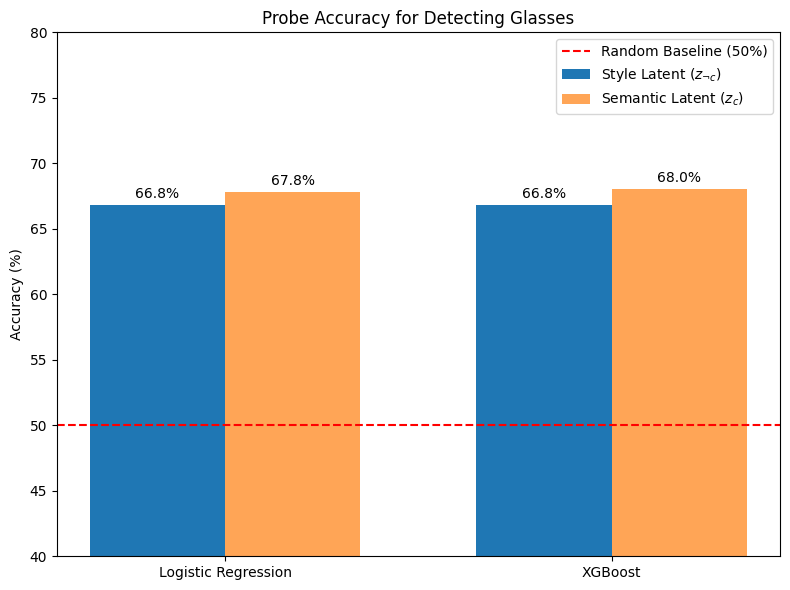

In [ ]:
def plot_probe_results(results_dict):
    """
    Visualization of linear and non-linear probe results.

    This plot compares the predictive performance of probes trained on:
      - the nuisance/style latent vector z_{¬c}
      - the semantic/color latent vector z_c

    The goal is to assess whether a non-target attribute (e.g. glasses)
    leaks into the semantic or nuisance subspaces.
    """
    model_names = list(results_dict.keys())  # e.g. ['Logistic Regression', 'XGBoost']
    style_scores = [results_dict[m]["Style"] * 100.0 for m in model_names]
    color_scores = [results_dict[m]["Color"] * 100.0 for m in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 6))

    bars_style = ax.bar(
        x - width / 2,
        style_scores,
        width,
        label=r"Style Latent ($z_{\neg c}$)",
        color="#1f77b4",
    )
    bars_color = ax.bar(
        x + width / 2,
        color_scores,
        width,
        label=r"Semantic Latent ($z_c$)",
        color="#ff7f0e",
        alpha=0.7,
    )

    # Random-guess baseline (binary attribute)
    ax.axhline(
        y=50.0,
        color="red",
        linestyle="--",
        label="Random Baseline (50%)",
    )

    ax.set_ylabel("Accuracy (%)")
    ax.set_title("Probe Accuracy for Detecting Glasses")
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylim(40, 80)
    ax.legend()

    # Annotate bars with numerical values
    def annotate_bars(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f"{height:.1f}%",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    annotate_bars(bars_style)
    annotate_bars(bars_color)

    fig.tight_layout()
    plt.show()

all_results = {
    "Logistic Regression": res_linear,
    "XGBoost": res_xgb,
}

plot_probe_results(all_results)


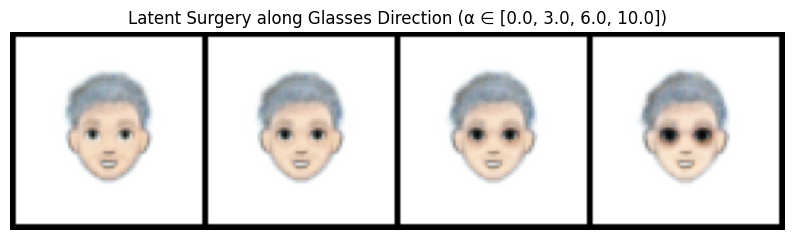

In [ ]:
def latent_surgery(model, clf, data_loader, device="cuda"):
    """
    Latent space intervention via linear probe directions.

    This experiment applies a controlled intervention along the
    "glasses" direction learned by a linear classifier trained on
    the nuisance latent z_{¬c}. The goal is to assess whether adding
    this direction induces the targeted attribute while preserving
    semantic content.
    """
    model.eval()

    # Direction corresponding to the "glasses" attribute
    glasses_vector = torch.tensor(clf.coef_[0], dtype=torch.float32).to(device)
    glasses_vector = glasses_vector / torch.norm(glasses_vector)

    # Select an image without glasses
    target_img = None
    with torch.no_grad():
        for x, labels in data_loader:
            no_glasses_mask = labels[:, 2] == 11  # class index for "no glasses"
            if no_glasses_mask.any():
                target_img = x[no_glasses_mask][:1].to(device)
                break

    if target_img is None:
        print("No image without glasses found.")
        return

    # Encode image
    _, z_c_list, z_not_c = encode_to_z(model, target_img)

    # Apply latent intervention with increasing strength
    alphas = [0.0, 3.0, 6.0, 10.0]
    generated = []

    with torch.no_grad():
        for alpha in alphas:
            z_not_c_mod = z_not_c + alpha * glasses_vector
            z_full = torch.cat(list(z_c_list) + [z_not_c_mod], dim=1)

            dec = model.decoder_input(z_full).view(-1, 64, 4, 4)
            img = model.decoder_conv(dec)
            generated.append(img.cpu())

    # Visualization
    grid = make_grid(torch.cat(generated), nrow=len(alphas), padding=2)
    plt.figure(figsize=(10, 4))
    plt.imshow(grid.permute(1, 2, 0).clamp(0, 1))
    plt.title(f"Latent Surgery along Glasses Direction (α ∈ {alphas})")
    plt.axis("off")
    plt.show()

surgery_loader = DataLoader(probe_dataset, batch_size=32, shuffle=True)
latent_surgery(model, linear_clf, surgery_loader, device=DEVICE)


--- Experiment: Leakage Surgery on Semantic Latent z_c ---
Loading labels for attributes: ['hair_color', 'face_color', 'glasses'] ...
Dataset loaded successfully. Attribute dimensions: {'hair_color': 10, 'face_color': 11, 'glasses': 12}


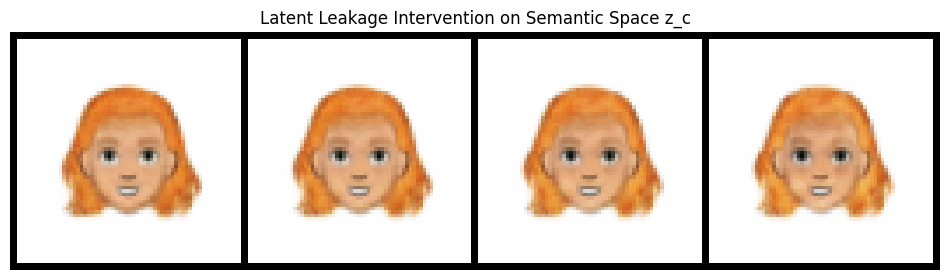

Interpretation:
- Appearance of glasses indicates leakage into z_c.
- Pure color changes indicate effective disentanglement.


In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import transforms


def run_leakage_surgery(model, data_dir, device="cuda", sample_limit=2000):
    """
    Latent leakage intervention on the semantic color space z_c.

    This experiment tests whether a non-target attribute (glasses) is
    spuriously encoded in the semantic latent subspace z_c. A linear
    probe is trained to predict glasses from z_c, and the corresponding
    direction is used to perform a controlled latent intervention.
    """
    print("--- Experiment: Leakage Surgery on Semantic Latent z_c ---")

    # --------------------------------------------------
    # 1. Dataset loading and latent extraction
    # --------------------------------------------------
    probe_transform = transforms.Compose(
        [transforms.Resize((64, 64)), transforms.ToTensor()]
    )

    probe_dataset = CartoonMultiLabelDataset(
        root_dir=data_dir,
        target_attributes=["hair_color", "face_color", "glasses"],
        transform=probe_transform,
    )
    probe_loader = DataLoader(probe_dataset, batch_size=64, shuffle=True)

    X_latent = []
    y_glasses = []

    model.eval()
    samples_collected = 0
    target_img = None

    with torch.no_grad():
        for x, labels in probe_loader:
            x = x.to(device)

            glasses_idx = labels[:, 2].cpu().numpy()
            glasses_binary = (glasses_idx != 11).astype(int)

            if target_img is None:
                mask = labels[:, 2] == 11
                if mask.any():
                    target_img = x[mask][:1]

            _, z_c_list, _ = encode_to_z(model, x)
            z_c_concat = torch.cat(list(z_c_list), dim=1).cpu().numpy()

            X_latent.append(z_c_concat)
            y_glasses.append(glasses_binary)

            samples_collected += x.size(0)
            if samples_collected >= sample_limit:
                break

    if target_img is None:
        print("Error: no image without glasses found.")
        return

    X = np.concatenate(X_latent)[:samples_collected]
    y = np.concatenate(y_glasses)[:samples_collected]

    # --------------------------------------------------
    # 2. Linear probe training
    # --------------------------------------------------
    clf = LogisticRegression(max_iter=1000, class_weight="balanced")
    clf.fit(X, y)

    glasses_direction = torch.tensor(
        clf.coef_[0], dtype=torch.float32, device=device
    )
    glasses_direction = glasses_direction / torch.norm(glasses_direction)

    # --------------------------------------------------
    # 3. Latent intervention
    # --------------------------------------------------
    _, z_c_list, z_not_c = encode_to_z(model, target_img)

    alphas = [0.0, 5.0, 10.0, 15.0]
    generated = []

    for alpha in alphas:
        z_c_concat = torch.cat(list(z_c_list), dim=1)
        z_c_modified = z_c_concat + alpha * glasses_direction

        z_c_split = torch.split(z_c_modified, [16, 16], dim=1)
        z_full = torch.cat(list(z_c_split) + [z_not_c], dim=1)

        dec = model.decoder_input(z_full).view(-1, 64, 4, 4)
        img = model.decoder_conv(dec)
        generated.append(img.cpu())

    # --------------------------------------------------
    # 4. Visualization
    # --------------------------------------------------
    grid = make_grid(torch.cat(generated), nrow=len(alphas), padding=2)
    plt.figure(figsize=(12, 5))
    plt.imshow(grid.permute(1, 2, 0).clamp(0, 1))
    plt.title("Latent Leakage Intervention on Semantic Space z_c")
    plt.axis("off")
    plt.show()

    print("Interpretation:")
    print("- Appearance of glasses indicates leakage into z_c.")
    print("- Pure color changes indicate effective disentanglement.")


# Example usage
run_leakage_surgery(model, DATA_DIR, device=DEVICE)


=== Experiment: Latent Correlation Heatmap ===
Loading labels for attributes: ['chin_length', 'eye_angle', 'eye_lashes', 'eye_lid', 'eyebrow_weight', 'eyebrow_thickness', 'face_shape', 'eye_slant', 'eyebrow_width', 'eye_eyebrow_distance'] ...
Dataset loaded successfully. Attribute dimensions: {'chin_length': 3, 'eye_angle': 3, 'eye_lashes': 2, 'eye_lid': 2, 'eyebrow_weight': 2, 'eyebrow_thickness': 4, 'face_shape': 7, 'eye_slant': 3, 'eyebrow_width': 3, 'eye_eyebrow_distance': 3}


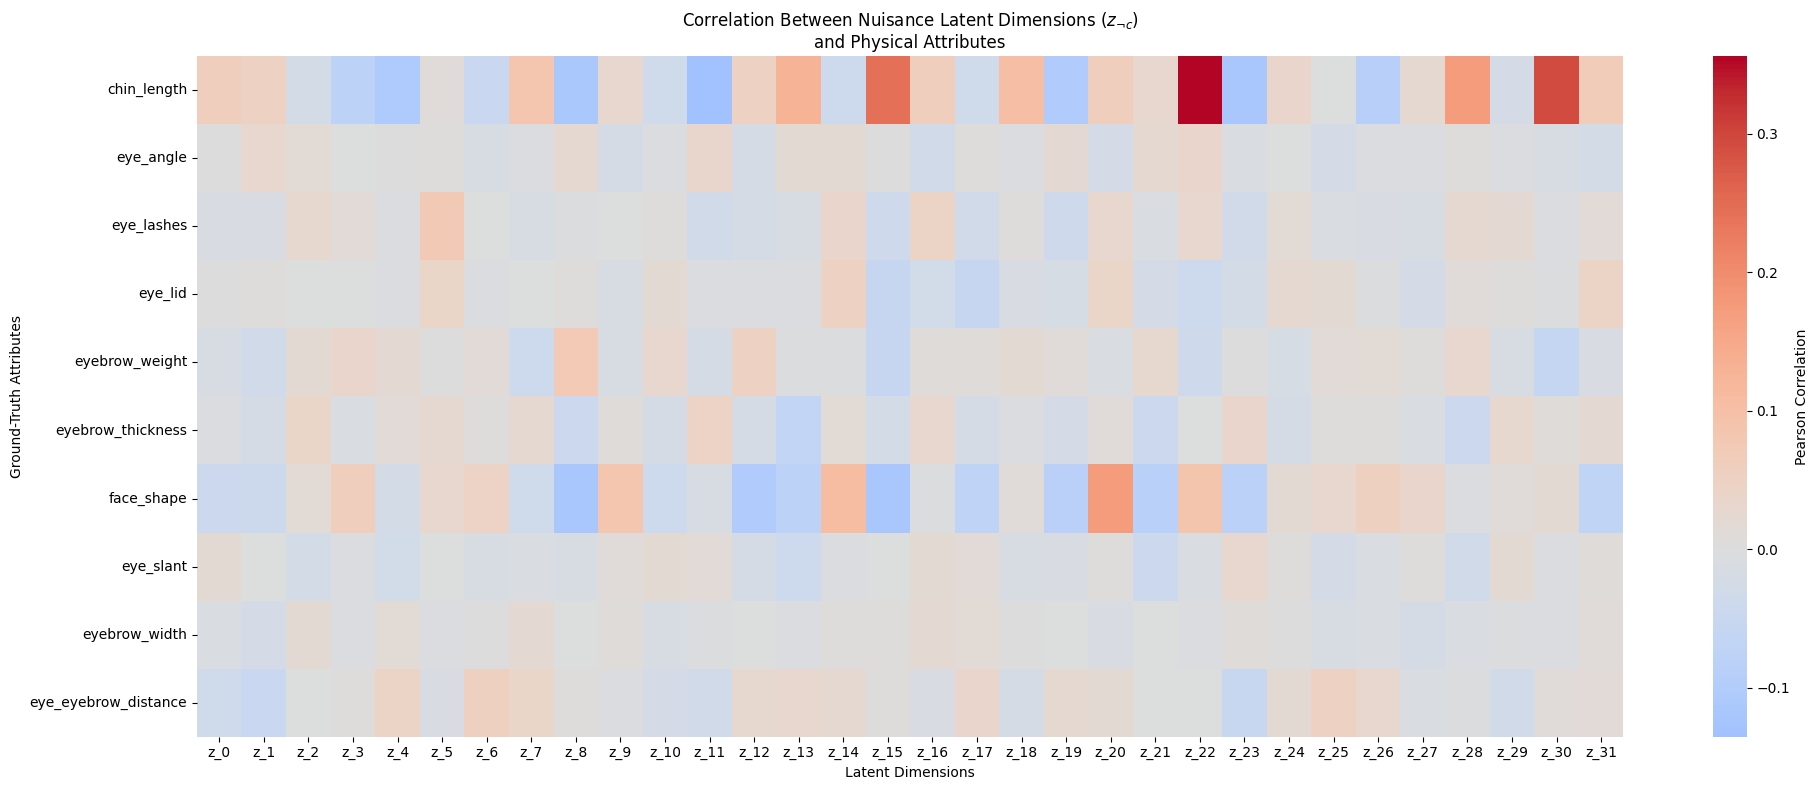

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def experiment_latent_correlation(
    model,
    data_dir,
    device="cuda",
    sample_limit=2000,
):
    """
    Correlation analysis between nuisance latent dimensions z_{¬c}
    and continuous / ordinal ground-truth attributes.

    This experiment evaluates whether unsupervised latent neurons
    encode interpretable physical attributes by measuring Pearson
    correlations between z_{¬c} and selected attributes.
    """
    print("=== Experiment: Latent Correlation Heatmap ===")

    # Attributes of interest
    interesting_attributes = [
        "chin_length",
        "eye_angle",
        "eye_lashes",
        "eye_lid",
        "eyebrow_weight",
        "eyebrow_thickness",
        "face_shape",
        "eye_slant",
        "eyebrow_width",
        "eye_eyebrow_distance",
    ]

    probe_transform = transforms.Compose(
        [transforms.Resize((64, 64)), transforms.ToTensor()]
    )

    probe_dataset = CartoonMultiLabelDataset(
        root_dir=data_dir,
        target_attributes=interesting_attributes,
        transform=probe_transform,
    )
    probe_loader = DataLoader(probe_dataset, batch_size=64, shuffle=True)

    latent_vectors = []
    attribute_vectors = []

    model.eval()
    samples_collected = 0

    with torch.no_grad():
        for x, labels in probe_loader:
            x = x.to(device)

            _, _, z_not_c = encode_to_z(model, x)
            latent_vectors.append(z_not_c.cpu().numpy())
            attribute_vectors.append(labels.cpu().numpy())

            samples_collected += x.size(0)
            if samples_collected >= sample_limit:
                break

    Z = np.concatenate(latent_vectors)[:samples_collected]
    A = np.concatenate(attribute_vectors)[:samples_collected]

    z_columns = [f"z_{i}" for i in range(Z.shape[1])]
    df_z = pd.DataFrame(Z, columns=z_columns)
    df_attr = pd.DataFrame(A, columns=interesting_attributes)

    full_df = pd.concat([df_z, df_attr], axis=1)
    corr = full_df.corr()

    cross_corr = corr.loc[interesting_attributes, z_columns]

    # Visualization
    plt.figure(figsize=(20, 8))
    sns.heatmap(
        cross_corr,
        cmap="coolwarm",
        center=0.0,
        cbar_kws={"label": "Pearson Correlation"},
        annot=False,
    )
    plt.title(
        "Correlation Between Nuisance Latent Dimensions ($z_{\\neg c}$)\n"
        "and Physical Attributes"
    )
    plt.xlabel("Latent Dimensions")
    plt.ylabel("Ground-Truth Attributes")
    plt.tight_layout()
    plt.show()

    return cross_corr


# Example usage
correlation_df = experiment_latent_correlation(model, DATA_DIR, device=DEVICE)


=== Latent Surgery: Chin Length (Neuron 22) ===
Loading labels for attributes: ['hair_color'] ...
Dataset loaded successfully. Attribute dimensions: {'hair_color': 10}


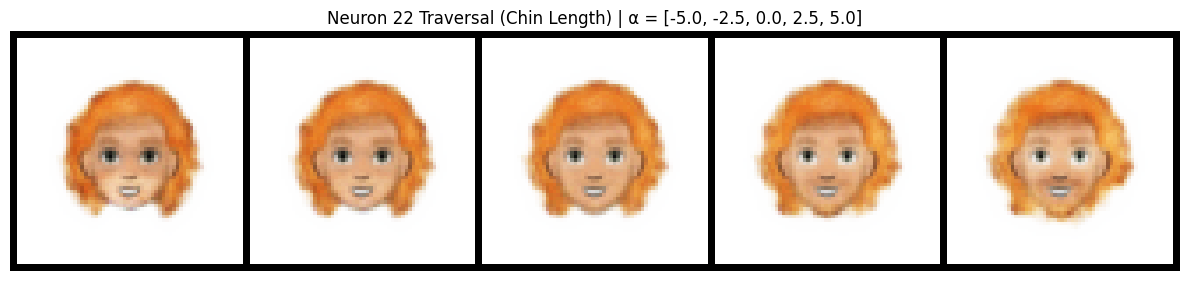

In [ ]:
def surgery_chin_length(model, data_dir, device="cuda"):
    """
    Latent surgery along a single nuisance dimension (neuron 22),
    identified as correlated with chin length.
    """
    print("=== Latent Surgery: Chin Length (Neuron 22) ===")

    transform = transforms.Compose(
        [transforms.Resize((64, 64)), transforms.ToTensor()]
    )

    dataset = CartoonMultiLabelDataset(
        root_dir=data_dir,
        target_attributes=["hair_color"],  # minimal loading
        transform=transform,
    )
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Unit direction targeting neuron 22 in z_{¬c}
    feature_vector = torch.zeros((1, model.z_not_c_dim), device=device)
    feature_vector[0, 22] = 1.0

    # Select a reference image
    target_img, _ = next(iter(loader))
    target_img = target_img[0:1].to(device)

    # Encode
    _, z_c_list, z_not_c = encode_to_z(model, target_img)

    # Latent manipulation
    alphas = [-5.0, -2.5, 0.0, 2.5, 5.0]
    results = []

    for alpha in alphas:
        z_not_c_new = z_not_c + alpha * feature_vector
        z_combined = torch.cat(list(z_c_list) + [z_not_c_new], dim=1)

        dec_in = model.decoder_input(z_combined).view(-1, 64, 4, 4)
        recon = model.decoder_conv(dec_in)
        results.append(recon.cpu())

    # Visualization
    grid = make_grid(torch.cat(results), nrow=len(alphas), padding=2)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).clip(0, 1))
    plt.title(f"Neuron 22 Traversal (Chin Length) | α = {alphas}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Example usage
surgery_chin_length(model, DATA_DIR, device=DEVICE)
